![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps%2FExperiment+Tracking&file=Vertex+AI+Experiments.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Experiment%20Tracking/Vertex%20AI%20Experiments.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FExperiment%2520Tracking%2FVertex%2520AI%2520Experiments.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Experiment%20Tracking/Vertex%20AI%20Experiments.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Experiment%20Tracking/Vertex%20AI%20Experiments.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Experiments

The work of ML is inherantly iterative and experimental, involving trying different approaches and comparing results to make decisions towards future iteration.  A key part of moving from ad-hoc coding to fully operationalize ML training is tracking inputs, outputs, and other parameters.  Keeping track of information within experiments is the goal of [Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments#experiments-experiment-runs). This hosted service lets you [log information](https://cloud.google.com/vertex-ai/docs/experiments/log-data) from each run, and even has [autologging](https://cloud.google.com/vertex-ai/docs/experiments/autolog-data) for common ML Frameworks.

The architecture of experiments is:
- The Vertex AI Experiments **Service** (setup by default)
    - An **Experiment**: Create, Delete
        - **Runs** of the Experiment: Start, End, Resume, Delete, Manage
            - Use Autologging for common frameworks (Keras, LightGBM, Pytorch Lightning, Scikit-learn, XGBoost, and more)
            - Directed logging for:
                - parameters (learning rate, epochs, ...)
                - metrics (accuracy, precision, ...)
                - classification metrics (confusion matrix, ROC curve data, ...)
                - time series metrics (metrics for each step(epoch) of training)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.51.0'),
    ('mlflow', 'mlflow', '1.27.0'),
    ('kfp', 'kfp'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

## API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'experiments'
SERIES = 'mlops'

# gcs bucket
GCS_BUCKET = PROJECT_ID

Packages

In [8]:
import os
import time
import importlib
from google.cloud import aiplatform
import kfp
from typing import NamedTuple

In [9]:
kfp.__version__

'2.7.0'

In [10]:
aiplatform.__version__

'1.51.0'

Clients

In [11]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [12]:
DIR = f"temp/{SERIES}-{EXPERIMENT}"

In [13]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [14]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---

## Getting Started

Create and Experiment, start a run, log information

### Create Experiment

Experiment are created (or reattached to) by specifying then with the Vertex AI SDK's `init` method:
- [`aiplatform.init`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_init)

In [26]:
aiplatform.init(experiment = f'{SERIES}-{EXPERIMENT}', experiment_description = 'An example experiment to demonstrate how it is used.')

<p><center>
    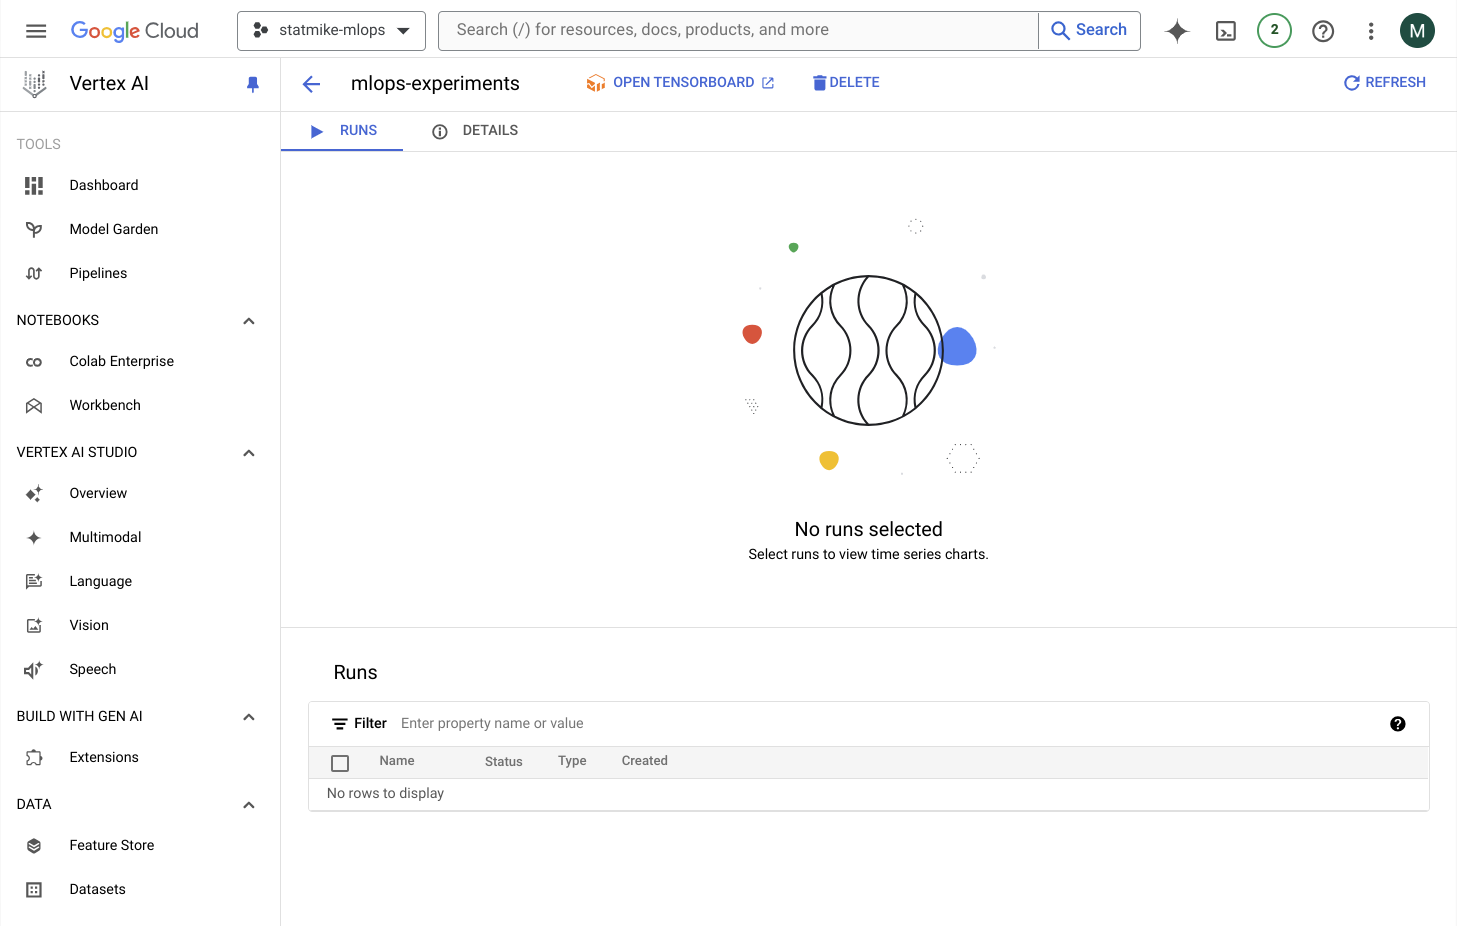
</center><p>

### Start Experiment Run

Start a run within an experiment with the `.start_run` method and attach to a previous run by using the `resume = True` parameter.
- [`aiplatform.start_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_start_run)

In [30]:
try:
    aiplatform.start_run('getting-started')
except Exception:
    aiplatform.start_run('getting-started', resume = True)

Associating projects/1026793852137/locations/us-central1/metadataStores/default/contexts/mlops-experiments-getting-started to Experiment: mlops-experiments


<p><center>
    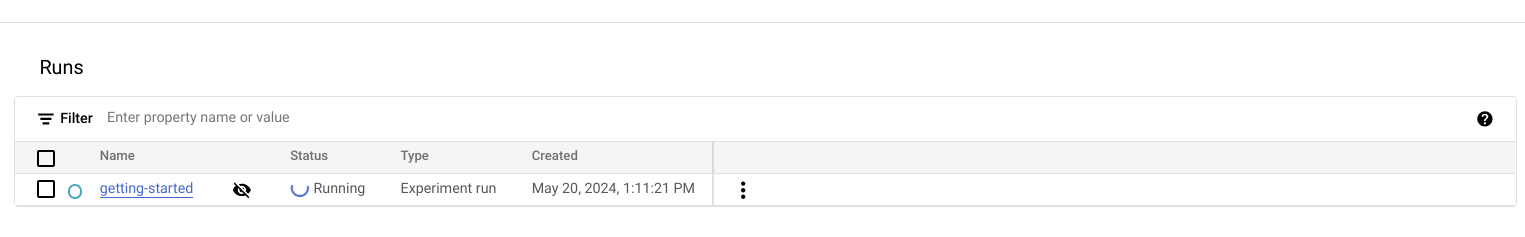
</center><p>

### Log Parameters

The `.log_params()` method is used for logging dictionaries of key:value pairs of parameters, like epochs, batch_size and learning_rate.
- [`aiplatform.log_params()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_params)

In [31]:
aiplatform.log_params(dict(epochs = 50, batch_size = 25, learning_rate = 0.1))

<p>
    <center>
        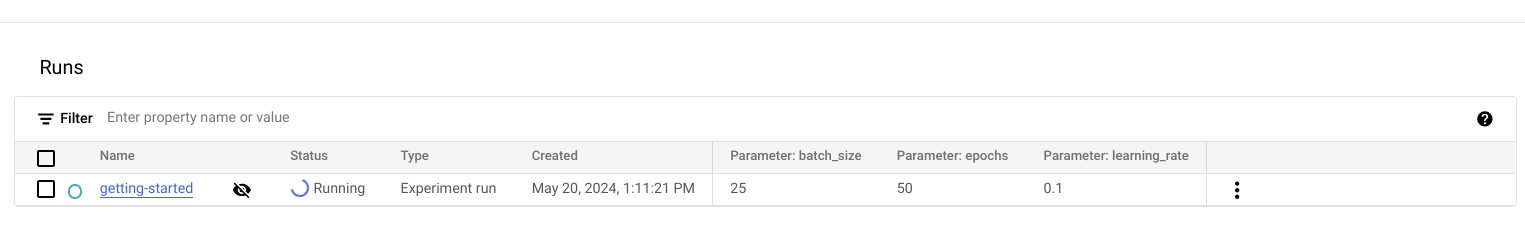
    </center>
<p>
<p>
    <center>
        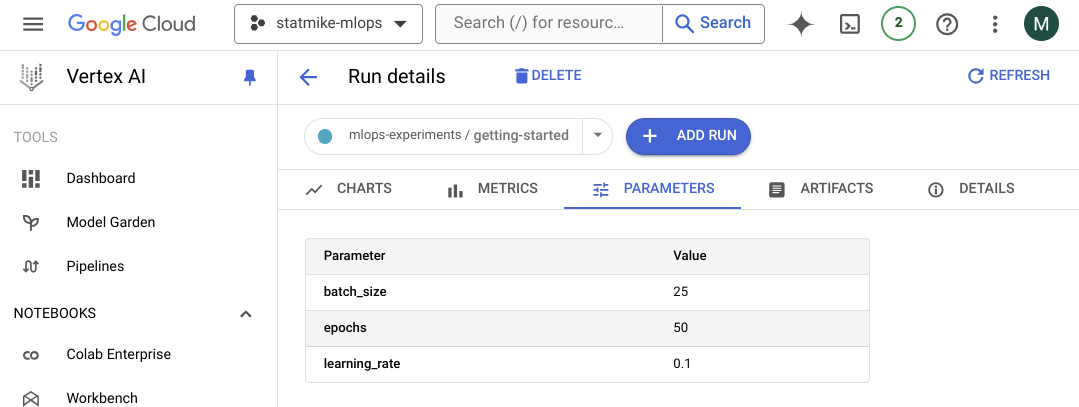
    </center>
<p>

### Log Metrics

The `.log_metrics()` method is used for logging dictionaries of key:value pairs of summary metrics like test_accuracy, train_accuracy, test_auc, and train_auc.
- [`aiplatform.log_metrics`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_metrics)

In [32]:
aiplatform.log_metrics(dict(train_acc = 0.967, test_acc = 0.952))

<p><center>
    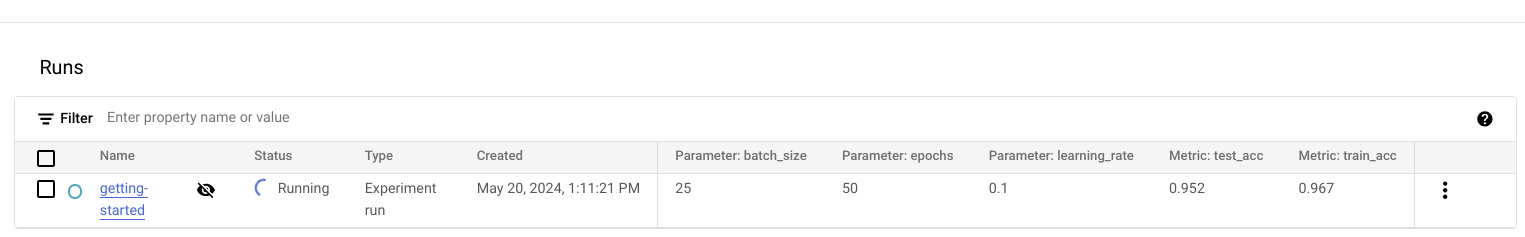
</center><p>
<p>
    <center>
        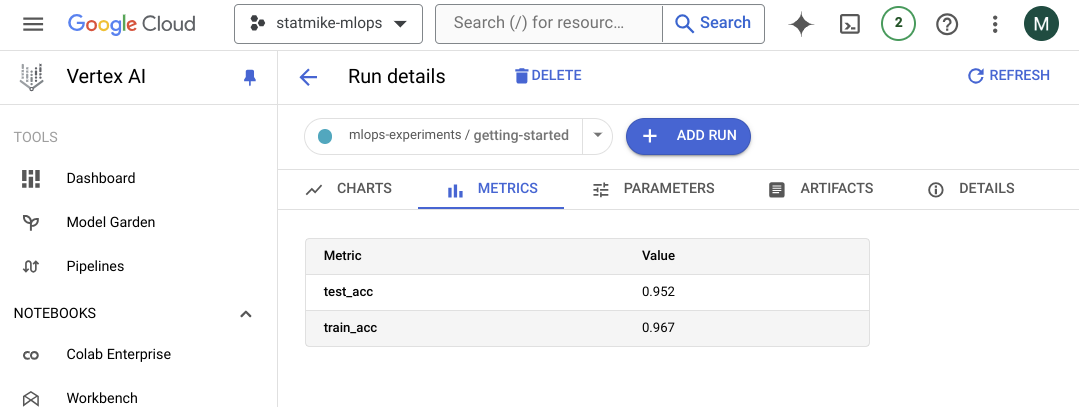
    </center>
<p>

### Log Classification Metrics

The `.log_classification_metrics()` method is used for logging classification metrics like confusion matrix and ROC curve values. This load the information as an artifact and even presents the data visually in the console as shown in the following screenshot.
- [`aiplatform.log_classification_metrics()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_classification_metrics)

In [34]:
aiplatform.log_classification_metrics(
    display_name = 'custom-class-metrics',
    labels = ['A', 'B'],
    matrix = [[83, 1], [2, 14]]
)

resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/c7988a8c-a540-48b8-9d9b-45666e33fc49
uri: 
schema_title:google.ClassificationMetrics

<p>
    <center>
        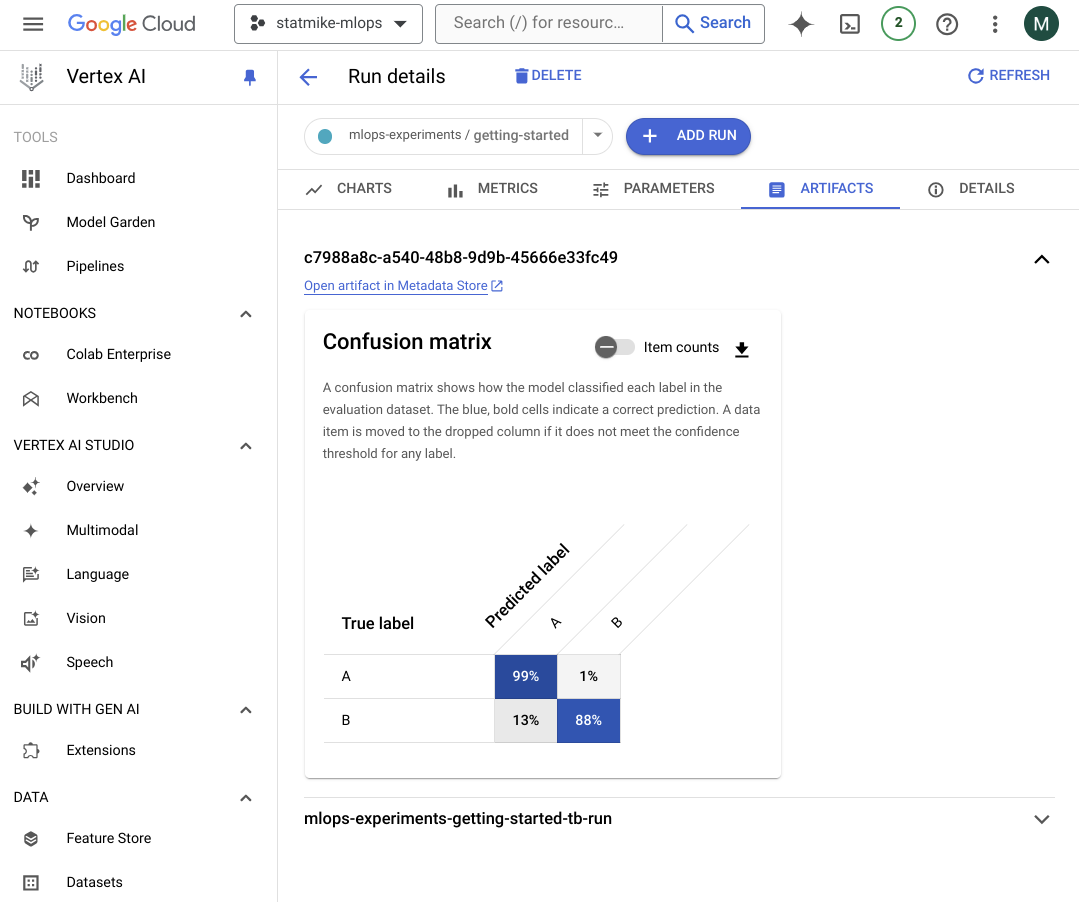
    </center>
<p>

### End Experiment Run

End a run within an experiment with the `.end_run` method.
- [`aiplatform.end_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_end_run)

In [37]:
aiplatform.end_run()

<p><center>
    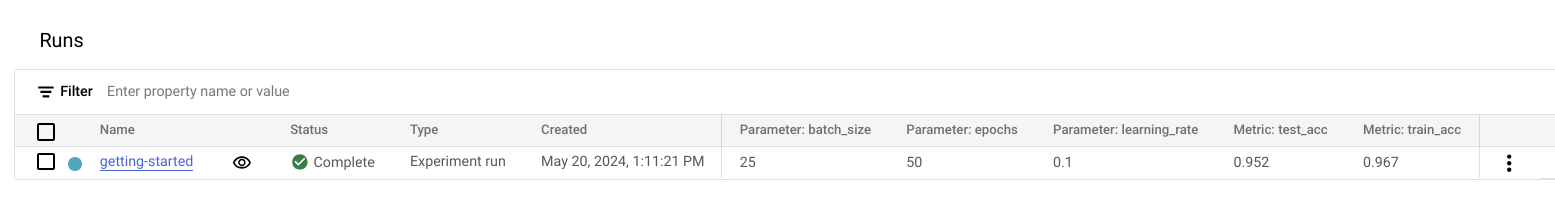
</center><p>

### Reopen Experiment Run

Reopen a run within an experiment with the `.start_run` method and attach to a previous run by using the `resume = True` parameter.
- [`aiplatform.start_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_start_run)

In [38]:
aiplatform.start_run('getting-started', resume = True)

<p><center>
    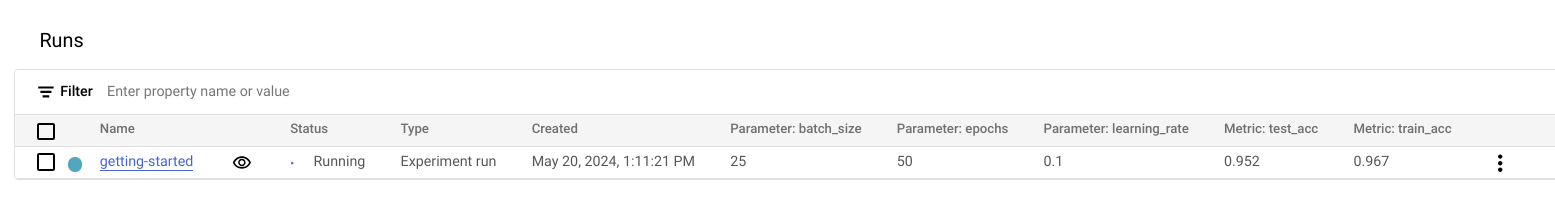
</center><p>

### Change/Update Values In Experiment Run

Continue adding or changing values for the experiment run:

In [39]:
aiplatform.log_params(dict(epochs = 70, batch_size = 30, learning_rate = 0.1, optimizer = 'adam'))

<p><center>
    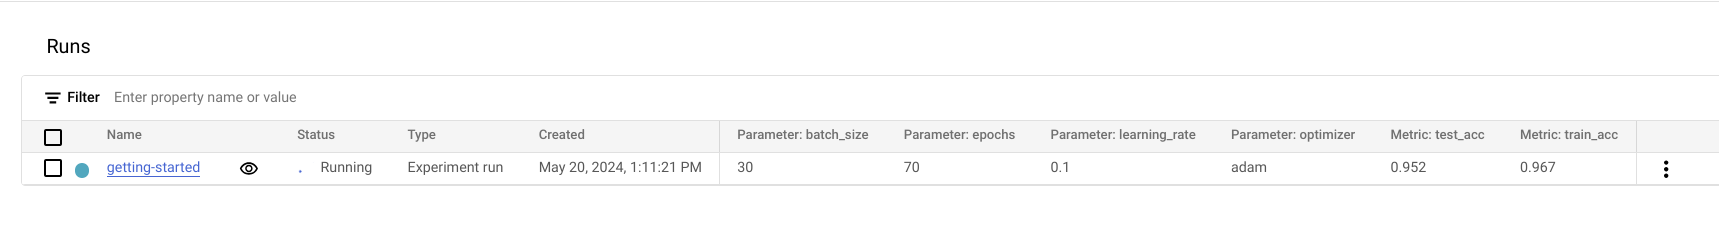
</center><p>

In [36]:
aiplatform.log_classification_metrics(
    fpr = [0.25, 0.15, 0.10, 0.08, 0.05, 0.03, 0.02, 0.01, 0.005],
    tpr = [0.95, 0.90, 0.82, 0.75, 0.65, 0.55, 0.40, 0.25, 0.10],
    threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)

resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/66203341-a1b9-4891-acc2-ff2e510f1483
uri: 
schema_title:google.ClassificationMetrics

<p>
    <center>
        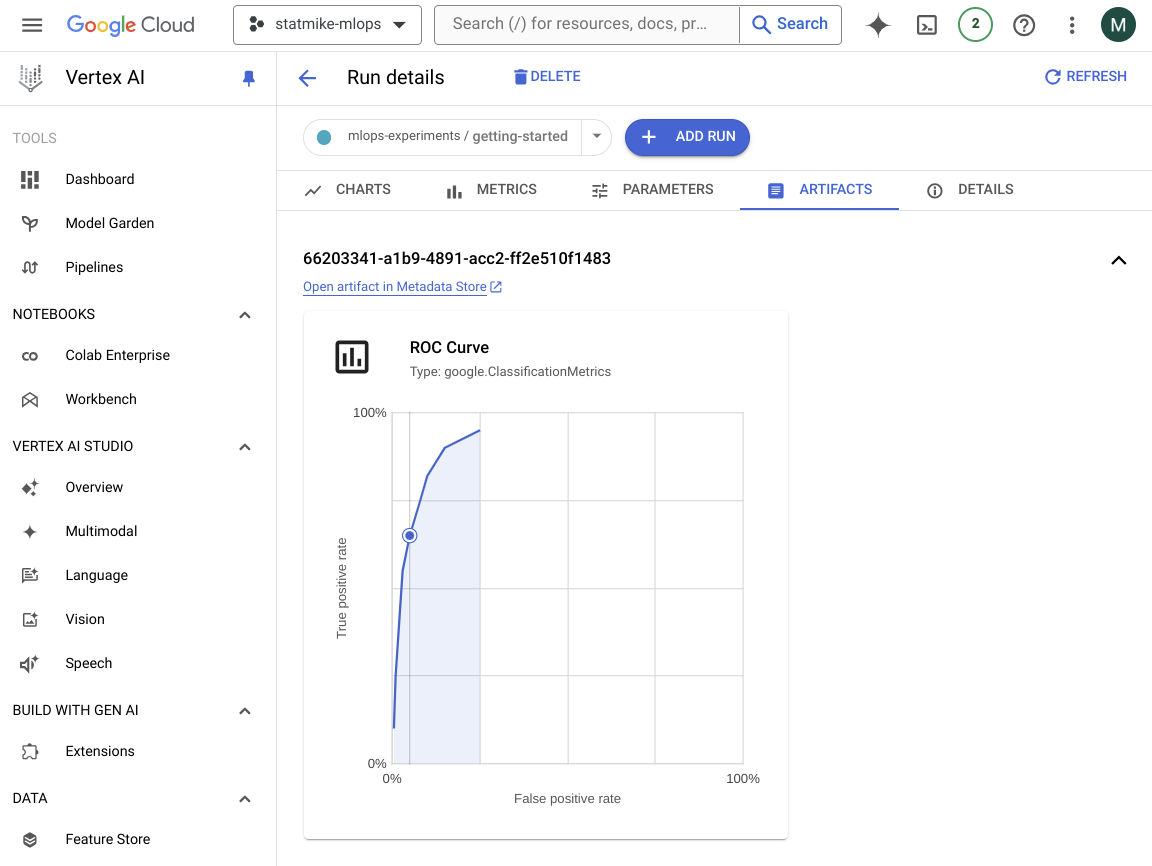
    </center>
<p>

### Change Status Of Experiment Run

End a run within an experiment with the `.end_run` method and include the desired state from the list below.
- [`aiplatform.end_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_end_run)

Possible `state` Values: [Documentation](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.Execution.State)
- `aiplatform.gapic.Execution.State.CACHED`
- `aiplatform.gapic.Execution.State.CANCELLED`
- `aiplatform.gapic.Execution.State.COMPLETE`
- `aiplatform.gapic.Execution.State.FAILED`
- `aiplatform.gapic.Execution.State.NEW`
- `aiplatform.gapic.Execution.State.RUNNING`

In [40]:
aiplatform.end_run(aiplatform.gapic.Execution.State.NEW)

<p><center>
    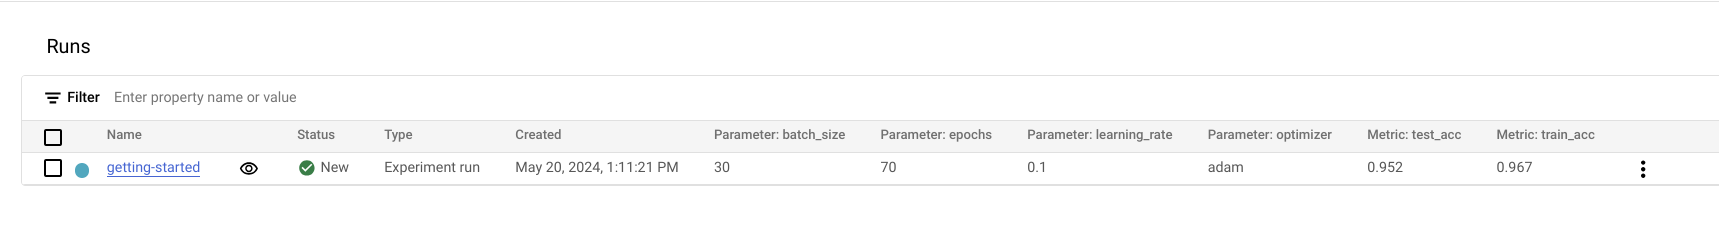
</center><p>

### Get Experiment Results

While the console has the visual review from the screenshots above, it is also helpful to be able to retrieve experiment runs to a local dataframe.

#### Experiment To DataFrame with `aiplatform.get_experiment_df`

Quickly retrieve the recent experiement, or any experiment with the `experiment = ` parameter:
- [`aiplatform.get_experiment_df`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_get_experiment_df)

In [41]:
experiment_df = aiplatform.get_experiment_df(experiment = f'{SERIES}-{EXPERIMENT}')

In [42]:
experiment_df

,experiment_name,run_name,run_type,state,param.optimizer,param.batch_size,param.epochs,param.learning_rate,metric.train_acc,metric.test_acc
0,mlops-experiments,getting-started,system.ExperimentRun,NEW,adam,30.0,70.0,0.1,0.967,0.952


#### Get And Review Experiment With `aiplatform.Experiment`

Use the Vertex AI SDK to directly retrieve the `Experiment` object and review it:
- [`aiplatform.Experiment.get`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Experiment)

In [45]:
experiment = aiplatform.Experiment.get(experiment_name = f'{SERIES}-{EXPERIMENT}')

In [46]:
experiment.get_data_frame()

,experiment_name,run_name,run_type,state,param.batch_size,param.optimizer,param.learning_rate,param.epochs,metric.train_acc,metric.test_acc
0,mlops-experiments,getting-started,system.ExperimentRun,NEW,30.0,adam,0.1,70.0,0.967,0.952


#### Get And Review Experiment Run with `aiplatform.ExperimentRun`

Use the Vertex AI SDK to directly retrieve and review all aspected of an experiment run, event artifacts and links to their lineage:
- [`aiplatform.ExperimentRun`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.ExperimentRun)

In [47]:
experiment_run = aiplatform.ExperimentRun.get(experiment = f'{SERIES}-{EXPERIMENT}', run_name = 'getting-started')

In [48]:
experiment_run.state

<State.NEW: 1>

In [49]:
experiment_run.get_params()

{'optimizer': 'adam', 'batch_size': 30.0, 'epochs': 70.0, 'learning_rate': 0.1}

In [50]:
experiment_run.get_metrics()

{'train_acc': 0.967, 'test_acc': 0.952}

In [51]:
experiment_run.get_classification_metrics()

[{'id': '66203341-a1b9-4891-acc2-ff2e510f1483',
  'display_name': '',
  'fpr': [0.25, 0.15, 0.1, 0.08, 0.05, 0.03, 0.02, 0.01, 0.005],
  'tpr': [0.95, 0.9, 0.82, 0.75, 0.65, 0.55, 0.4, 0.25, 0.1],
  'threshold': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
 {'id': 'da54c9de-4610-46fc-b6df-d81b8d3b3a1e',
  'display_name': '',
  'fpr': [0.25, 0.15, 0.1, 0.08, 0.05, 0.03, 0.02, 0.01, 0.005],
  'tpr': [0.95, 0.9, 0.82, 0.75, 0.65, 0.55, 0.4, 0.25, 0.1],
  'threshold': [0.1, 0.3, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
 {'id': 'c7988a8c-a540-48b8-9d9b-45666e33fc49',
  'display_name': 'custom-class-metrics',
  'labels': ['A', 'B'],
  'matrix': [[83.0, 1.0], [2.0, 14.0]]}]

In [52]:
experiment_run.get_artifacts()

 resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/66203341-a1b9-4891-acc2-ff2e510f1483
 uri: 
 schema_title:google.ClassificationMetrics,
 resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/da54c9de-4610-46fc-b6df-d81b8d3b3a1e
 uri: 
 schema_title:google.ClassificationMetrics,
 resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/c7988a8c-a540-48b8-9d9b-45666e33fc49
 uri: 
 schema_title:google.ClassificationMetrics,
 resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/mlops-experiments-getting-started-tb-run
 uri: https://us-central1-aiplatform.googleapis.com/v1/projects/1026793852137/locations/us-central1/tensorboards/1077789676057657344/experiments/mlops-experiments/runs/getting-started
 schema_title:google.VertexTensorboardRun]

In [56]:
experiment_run.get_artifacts()[1].lineage_console_uri

'https://console.cloud.google.com/vertex-ai/locations/us-central1/metadata-stores/default/artifacts/da54c9de-4610-46fc-b6df-d81b8d3b3a1e?project=1026793852137'

## AutoLogging

Vertex AI Experiments has [autologging] for many common frameworks.  In this section autologging is used with a Keras model to show how the parameters, metrics and even time series metrics from the epochs are all automatically captured by experiments.
- [Autolog data to an experiment run](https://cloud.google.com/vertex-ai/docs/experiments/autolog-data)
- [Example from Tensorflow Tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner) (using Keras API)


### Start Autologging

Autologging is started with `aiplatform.autolog()` and while it will automatically create a run name for for the current experiement it can also be followed with `aiplatform.start_run(run = run_name)` to specifically name the run as show here:
- [`aiplatform.autolog()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_autolog)
- [`aiplatform.start_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_start_run)

In [61]:
aiplatform.autolog()
aiplatform.start_run(run = 'autologging-example')

Associating projects/1026793852137/locations/us-central1/metadataStores/default/contexts/mlops-experiments-autologging-example to Experiment: mlops-experiments


In [62]:
# Tensorflow/Keras
import tensorflow as tf
import keras

# data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# model
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(10)
])

# compile and train
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)
model.fit(x_train, y_train, batch_size = 30, epochs = 10, validation_split = 0.1)
model.evaluate(x_test,  y_test, verbose=2)

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8558 - loss: 0.4874 - val_accuracy: 0.9622 - val_loss: 0.1377
Epoch 2/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9522 - loss: 0.1640 - val_accuracy: 0.9742 - val_loss: 0.0957
Epoch 3/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9661 - loss: 0.1125 - val_accuracy: 0.9767 - val_loss: 0.0784
Epoch 4/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9726 - loss: 0.0867 - val_accuracy: 0.9810 - val_loss: 0.0714
Epoch 5/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9756 - loss: 0.0774 - val_accuracy: 0.9808 - val_loss: 0.0664
Epoch 6/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9794 - loss: 0.0651 - val_accuracy: 0.9802 - val_loss: 0.0666
Epoch 7/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9816 - loss: 0.0580 - val_accuracy: 0.9837 - val_loss: 0.0638
Epoch 8/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9823 - loss: 0.0536 - 

[0.07065535336732864, 0.9789999723434448]

### Add Log Parameters (example)

Use `.log_params()` method to add addition key:value pairs:
- [`aiplatform.log_params()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_params)

In [64]:
aiplatform.log_params(dict(ide='Vertex AI Workbench'))

### Stop Autologging

Autologging is stopped with `aiplatform.autolog(disable = True)` after ending the run with `aiplatform.end_run()`:
- [`aiplatform.autolog(disable = True)`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_autolog)
- [`aiplatform.end_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_end_run)

In [65]:
aiplatform.end_run()
aiplatform.autolog(disable = True)

### Get Experiment Results

While the console has the visual review from the screenshots above, it is also helpful to be able to retrieve experiment runs to a local dataframe.  

In this case, two runs for the experiment are returned and all the autologging can be reviewed for the new run named 'autologging-example'.

#### Experiment To DataFrame with `aiplatform.get_experiment_df`

Quickly retrieve the recent experiement, or any experiment with the `experiment = ` parameter:
- [`aiplatform.get_experiment_df`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_get_experiment_df)

In [66]:
experiment_df = aiplatform.get_experiment_df(experiment = f'{SERIES}-{EXPERIMENT}')

In [67]:
experiment_df

,experiment_name,run_name,run_type,state,param.optimizer_use_ema,param.batch_size,param.optimizer_beta_1,param.sample_weight,param.epochs,param.shuffle,...,metric.loss,metric.val_loss,metric.accuracy,metric.validation_accuracy,metric.train_acc,metric.test_acc,time_series_metric.val_accuracy,time_series_metric.loss,time_series_metric.accuracy,time_series_metric.val_loss
0,mlops-experiments,autologging-example,system.ExperimentRun,COMPLETE,False,30,0.9,None,10,True,...,0.304396,0.137741,0.910537,0.982833,NaN,NaN,0.982833,0.045868,0.984685,0.067669
1,mlops-experiments,getting-started,system.ExperimentRun,NEW,NaN,30.0,NaN,NaN,70.0,NaN,...,NaN,NaN,NaN,NaN,0.967,0.952,NaN,NaN,NaN,NaN


#### Get And Review Experiment With `aiplatform.Experiment`

Use the Vertex AI SDK to directly retrieve the `Experiment` object and review it:
- [`aiplatform.Experiment.get`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Experiment)

In [68]:
experiment = aiplatform.Experiment.get(experiment_name = f'{SERIES}-{EXPERIMENT}')

In [69]:
experiment.get_data_frame()

,experiment_name,run_name,run_type,state,param.sample_weight,param.batch_size,param.initial_epoch,param.optimizer_beta_1,param.validation_split,param.optimizer_clipnorm,...,metric.loss,metric.val_loss,metric.accuracy,metric.validation_accuracy,metric.train_acc,metric.test_acc,time_series_metric.val_accuracy,time_series_metric.loss,time_series_metric.accuracy,time_series_metric.val_loss
0,mlops-experiments,autologging-example,system.ExperimentRun,COMPLETE,None,30,0,0.9,0.1,None,...,0.304396,0.137741,0.910537,0.982833,NaN,NaN,0.982833,0.045868,0.984685,0.067669
1,mlops-experiments,getting-started,system.ExperimentRun,NEW,NaN,30.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.967,0.952,NaN,NaN,NaN,NaN


#### Get And Review Experiment Run with `aiplatform.ExperimentRun`

Use the Vertex AI SDK to directly retrieve and review all aspected of an experiment run, event artifacts and links to their lineage:
- [`aiplatform.ExperimentRun`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.ExperimentRun)

In [70]:
experiment_run = aiplatform.ExperimentRun.get(experiment = f'{SERIES}-{EXPERIMENT}', run_name = 'autologging-example')

In [71]:
experiment_run.state

<State.COMPLETE: 3>

In [72]:
experiment_run.get_params()

{'optimizer_use_ema': 'False',
 'batch_size': '30',
 'optimizer_beta_1': '0.9',
 'sample_weight': 'None',
 'shuffle': 'True',
 'epochs': '10',
 'optimizer_amsgrad': 'False',
 'optimizer_name': 'adam',
 'ide': 'Vertex AI Workbench',
 'optimizer_clipnorm': 'None',
 'optimizer_epsilon': '1e-07',
 'validation_freq': '1',
 'optimizer_weight_decay': 'None',
 'optimizer_gradient_accumulation_steps': 'None',
 'optimizer_ema_overwrite_frequency': 'None',
 'initial_epoch': '0',
 'optimizer_global_clipnorm': 'None',
 'class_weight': 'None',
 'validation_split': '0.1',
 'optimizer_ema_momentum': '0.99',
 'optimizer_learning_rate': '0.0010000000474974513',
 'optimizer_beta_2': '0.999',
 'validation_steps': 'None',
 'optimizer_loss_scale_factor': 'None',
 'steps_per_epoch': 'None',
 'validation_batch_size': 'None',
 'optimizer_clipvalue': 'None'}

In [73]:
experiment_run.get_metrics()

{'validation_loss': 0.06766892224550247,
 'accuracy': 0.91053706407547,
 'loss': 0.3043956458568573,
 'val_loss': 0.13774137198925018,
 'val_accuracy': 0.9621666669845581,
 'validation_accuracy': 0.9828333258628845}

In [74]:
experiment_run.get_classification_metrics()

[]

In [75]:
experiment_run.get_artifacts()

 resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/mlops-experiments-autologging-example-tb-run
 uri: https://us-central1-aiplatform.googleapis.com/v1/projects/1026793852137/locations/us-central1/tensorboards/1077789676057657344/experiments/mlops-experiments/runs/autologging-example
 schema_title:google.VertexTensorboardRun]

#### Console Review

Visiting the Experiment in the console showcases the visual presentation of the artifact information:

**Experiment View**
<p>
    <center>
        <img src="attachment:36443f94-9100-4189-b7d7-bc394e8efc50.png" width="75%">
    </center>
<p>

**Experiment Run: Chart View**
<p>
    <center>
        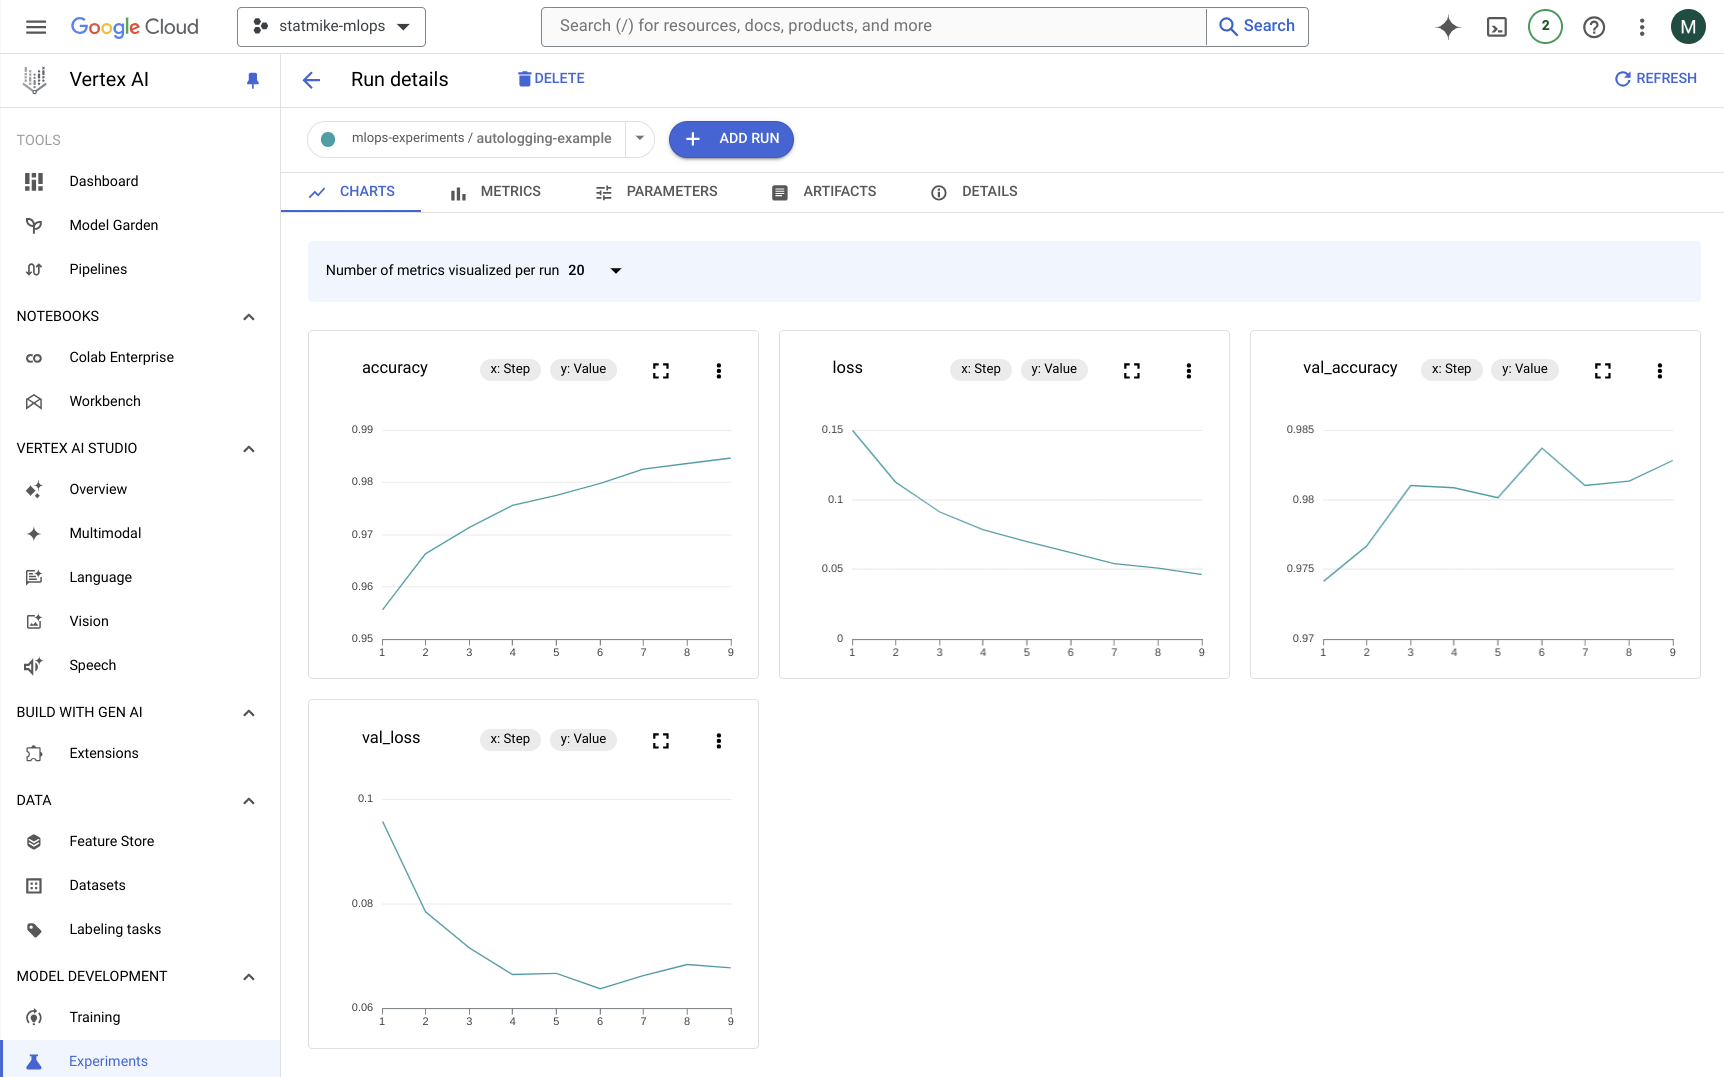
    </center>
<p>

**Experiment Run: Metrics View**
<p>
    <center>
        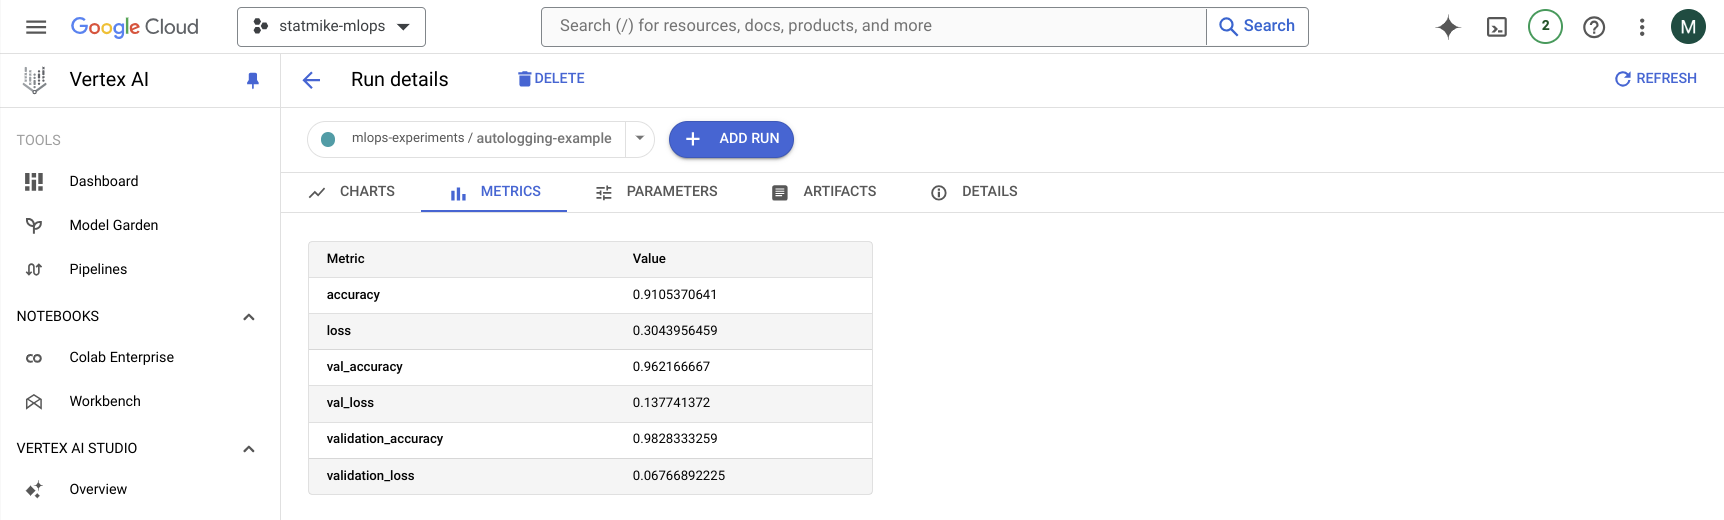
    </center>
<p>

**Experiment Run: Parameter View**
<p>
    <center>
        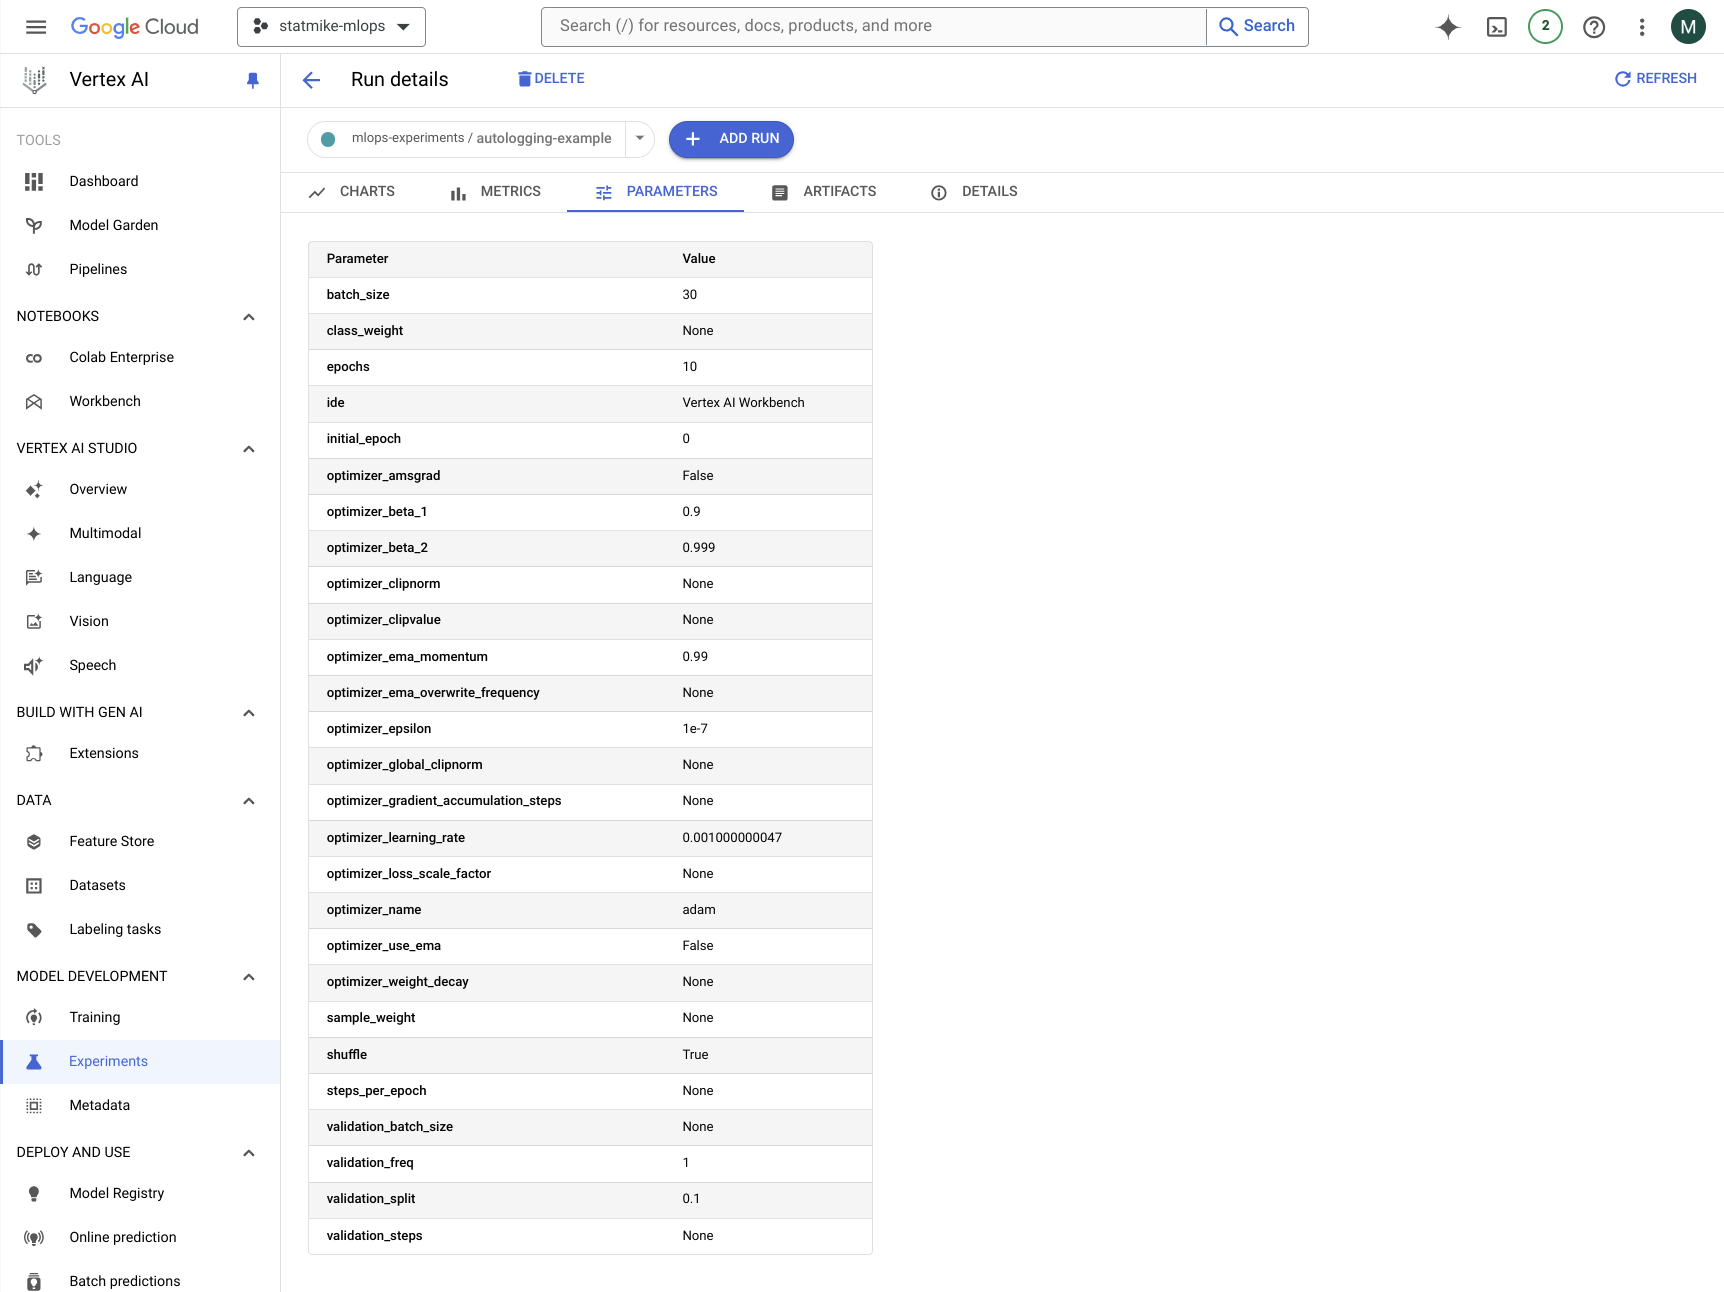
    </center>
<p>

**Experiment Run: Detail View**
<p>
    <center>
        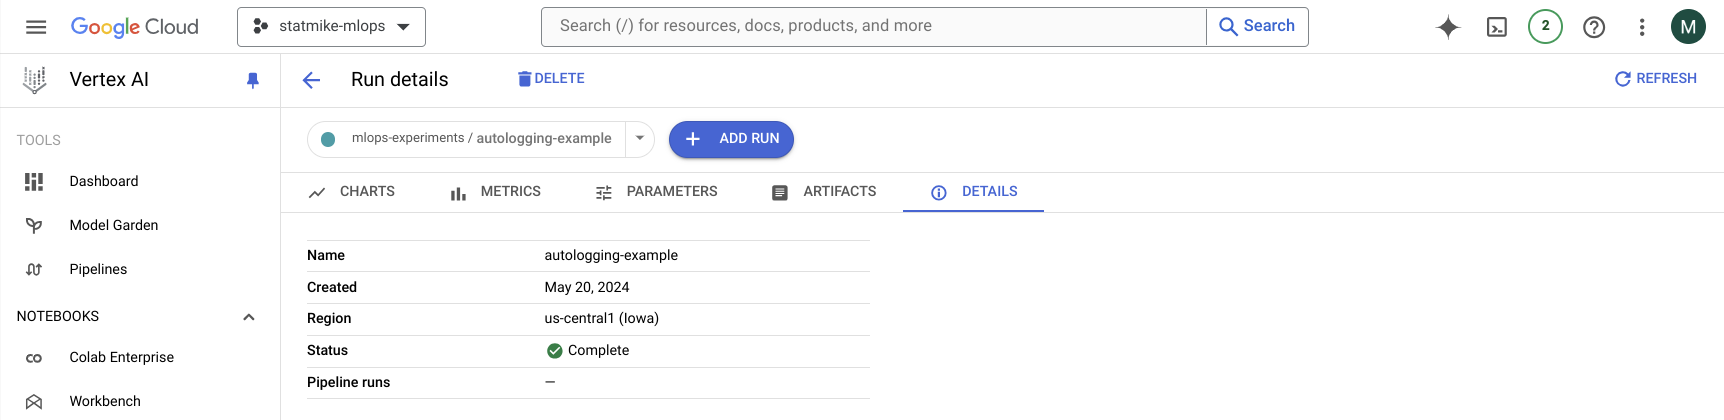
    </center>
<p>

---
## Pipeline Run Logging

Vertex AI Pipelines, the primary subject of this series (see header), are great at tracking input and outputs to components.  These include both parameters and artifacts.  Associating a pipeline run with an experiment is easy and the corresponding pipeline parameters and artifacts get included in the Experiment.  This section will show how to associate a pipeline with an experiment run.

There are two paths to doing this:
- Run a pipeline job and set it to create a new run for an experiment.  This can be latter added to like any other experiment run.
- Add a completed pipeline job to an experiment run

### Create A Pipeline

This section recreates the pipeline uses in the [Vertex AI Pipelines - Introduction](../Pipelines/Vertex%20AI%20Pipelines%20-%20Introduction.ipynb) workflow.  See that workflow for a walkthrough of all the details.

Simple component with multiple inputs of different data types and outputs a dictionary.

In [76]:
@kfp.dsl.component(
    base_image = "python:3.11",
    packages_to_install = ["pandas"]
)
def example_parameters(
    in_str: str,
    in_int: int,
    in_float: float,
    in_bool: bool,
    in_list: list
) -> dict:
    results = dict(
        ex_str = in_str,
        ex_int = in_int,
        ex_float = in_float,
        ex_bool = in_bool,
        ex_list = in_list
    )
    return results

Simple component that take input parameters and outputs an artifact.

In [77]:
@kfp.dsl.component(
    base_image = "python:3.10",
    packages_to_install = ["pandas"]
)
def example_artifact(
    metadata: dict
) -> kfp.dsl.Artifact:
    ex_artifact = kfp.dsl.Artifact(
        metadata = metadata,
        uri = 'https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#artifact-types'
    )
    return ex_artifact

#### Create Pipeline

In [84]:
@kfp.dsl.pipeline(
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root'
)
def intro_pipeline(
    in_str: str,
    in_int: int,
    in_float: float,
    in_bool: bool,
    in_list: list
) -> dict:
    
    task1 = example_parameters(
        in_str = in_str,
        in_int = in_int,
        in_float = in_float,
        in_bool = in_bool,
        in_list = in_list
    )
    
    with kfp.dsl.If(in_bool == True, name = 'Proceed If True'):
        task2 = example_artifact(metadata = task1.output)

    return task1.output

#### Compile Pipeline

In [85]:
kfp.compiler.Compiler().compile(
    pipeline_func = intro_pipeline,
    package_path = f'{DIR}/{SERIES}-{EXPERIMENT}.yaml'
)

### Pipeline Run As A New Experiment Run

Running the pipeline job on Vertex AI Pipelines uses the same Vertex AI SDK method as all pipeline runs, but with an additional parameter for the experiment name with the `.submit()` method:
- [`aiplatform.PipelineJob()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

In [86]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"pipeline-first",
    template_path = f"{DIR}/{SERIES}-{EXPERIMENT}.yaml",
    parameter_values = dict(
        in_str = 'An Example String',
        in_int = 45,
        in_float = 4.5,
        in_bool = True,
        in_list = [1, 27, 'Another String']
    ),
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root',
    enable_caching = None # True (enabled), False (disable), None (defer to component level caching) 
)
response = pipeline_job.submit(
    service_account = SERVICE_ACCOUNT,
    experiment = f'{SERIES}-{EXPERIMENT}'
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/intro-pipeline-20240521014640?project=1026793852137
Associating projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640 to Experiment: mlops-experiments


In [87]:
pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob run completed. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521014640


In [92]:
pipeline_job.name

'intro-pipeline-20240521014640'

#### Experiment To DataFrame with `aiplatform.get_experiment_df`

Quickly retrieve the recent experiement, or any experiment with the `experiment = ` parameter:
- [`aiplatform.get_experiment_df`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_get_experiment_df)

In [88]:
experiment_df = aiplatform.get_experiment_df(experiment = f'{SERIES}-{EXPERIMENT}')

In [89]:
experiment_df

,experiment_name,run_name,run_type,state,param.in_bool,param.in_list,param.in_str,param.in_int,param.in_float,param.sample_weight,...,metric.validation_accuracy,metric.val_loss,metric.loss,metric.val_accuracy,metric.train_acc,metric.test_acc,time_series_metric.val_accuracy,time_series_metric.loss,time_series_metric.accuracy,time_series_metric.val_loss
0,mlops-experiments,intro-pipeline-20240521014640,system.PipelineRun,COMPLETE,True,"[1.0, 27.0, Another String]",An Example String,45.0,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mlops-experiments,autologging-example,system.ExperimentRun,COMPLETE,NaN,NaN,NaN,NaN,NaN,None,...,0.982833,0.137741,0.304396,0.962167,NaN,NaN,0.982833,0.045868,0.984685,0.067669
2,mlops-experiments,getting-started,system.ExperimentRun,NEW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.967,0.952,NaN,NaN,NaN,NaN


#### Get And Review Experiment With `aiplatform.Experiment`

Use the Vertex AI SDK to directly retrieve the `Experiment` object and review it:
- [`aiplatform.Experiment.get`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Experiment)

In [90]:
experiment = aiplatform.Experiment.get(experiment_name = f'{SERIES}-{EXPERIMENT}')

In [91]:
experiment.get_data_frame()

,experiment_name,run_name,run_type,state,param.in_bool,param.in_list,param.in_str,param.in_int,param.in_float,param.optimizer_use_ema,...,metric.loss,metric.val_loss,metric.validation_accuracy,metric.accuracy,metric.train_acc,metric.test_acc,time_series_metric.val_accuracy,time_series_metric.loss,time_series_metric.accuracy,time_series_metric.val_loss
0,mlops-experiments,intro-pipeline-20240521014640,system.PipelineRun,COMPLETE,True,"[1.0, 27.0, Another String]",An Example String,45.0,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mlops-experiments,autologging-example,system.ExperimentRun,COMPLETE,NaN,NaN,NaN,NaN,NaN,False,...,0.304396,0.137741,0.982833,0.910537,NaN,NaN,0.982833,0.045868,0.984685,0.067669
2,mlops-experiments,getting-started,system.ExperimentRun,NEW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.967,0.952,NaN,NaN,NaN,NaN


#### Get And Review Experiment Run with `aiplatform.ExperimentRun`

Use the Vertex AI SDK to directly retrieve and review all aspected of an experiment run, event artifacts and links to their lineage:
- [`aiplatform.ExperimentRun`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.ExperimentRun)

In [141]:
#experiment_run = aiplatform.ExperimentRun.get(experiment = f'{SERIES}-{EXPERIMENT}', run_name = 'intro-pipeline-20240521014640')

In [140]:
#experiment_run.get_logged_pipeline_jobs()[0]

**Experiment Run: Parameter View**
<p>
    <center>
        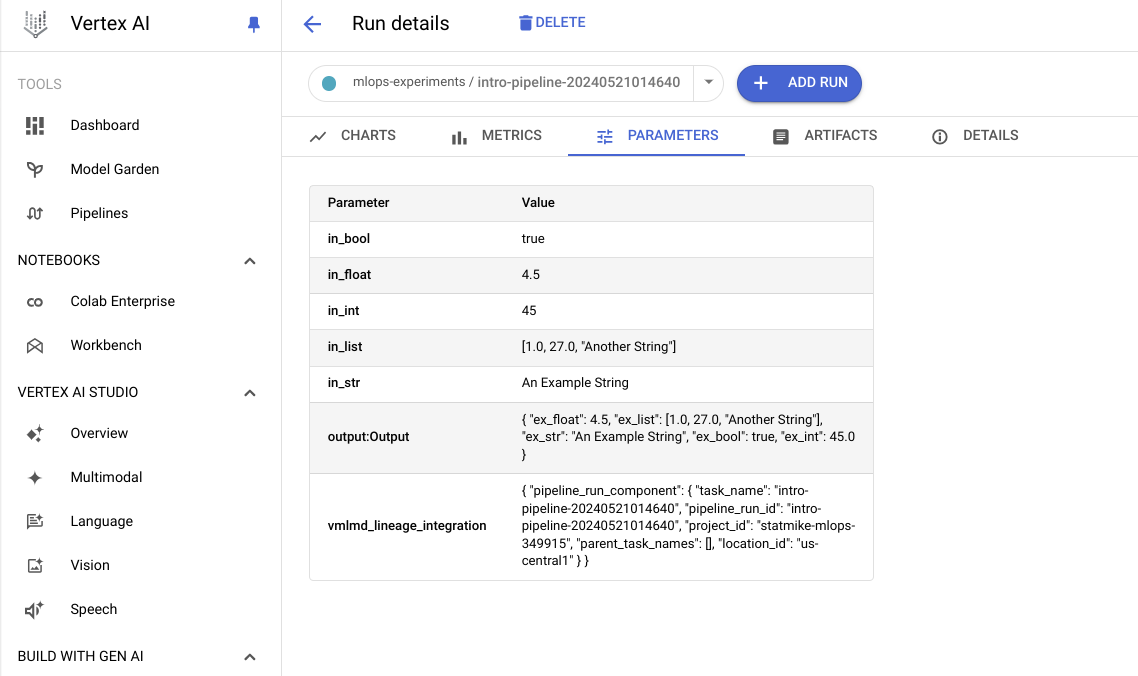
    </center>
<p>

### Add A Pipeline Run To An Existing Experiment Run

Running the pipeline job on Vertex AI Pipelines uses the same Vertex AI SDK method as all pipeline runs:
- [`aiplatform.PipelineJob()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

In [102]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"pipeline-first",
    template_path = f"{DIR}/{SERIES}-{EXPERIMENT}.yaml",
    parameter_values = dict(
        in_str = 'An Different Example String',
        in_int = 450,
        in_float = 4917.8765,
        in_bool = True,
        in_list = [1, 27, 38, 42, 'Another String']
    ),
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root',
    enable_caching = None # True (enabled), False (disable), None (defer to component level caching) 
)
response = pipeline_job.submit(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/intro-pipeline-20240521020042?project=1026793852137


In [103]:
pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob run completed. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042


In [104]:
pipeline_job.name

'intro-pipeline-20240521020042'

### Create Experiment Run

Start a run within an experiment with the `.start_run` method and attach to a previous run by using the `resume = True` parameter.
- [`aiplatform.start_run()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_start_run)

In [123]:
aiplatform.start_run('example-with-pipeline-added')#, resume= True)

In [124]:
aiplatform.log_params(dict(ide = 'Vertex AI Workbench'))

In [125]:
aiplatform.log(pipeline_job = pipeline_job)

In [126]:
aiplatform.end_run()

#### Experiment To DataFrame with `aiplatform.get_experiment_df`

Quickly retrieve the recent experiement, or any experiment with the `experiment = ` parameter:
- [`aiplatform.get_experiment_df`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_get_experiment_df)

In [127]:
experiment_df = aiplatform.get_experiment_df(experiment = f'{SERIES}-{EXPERIMENT}')

In [128]:
experiment_df

,experiment_name,run_name,run_type,state,param.ide,param.in_float,param.in_list,param.in_str,param.in_int,param.in_bool,...,metric.validation_accuracy,metric.val_loss,metric.loss,metric.accuracy,metric.train_acc,metric.test_acc,time_series_metric.val_accuracy,time_series_metric.loss,time_series_metric.accuracy,time_series_metric.val_loss
0,mlops-experiments,example-with-pipeline-added,system.ExperimentRun,COMPLETE,Vertex AI Workbench,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mlops-experiments,intro-pipeline-20240521014640,system.PipelineRun,COMPLETE,NaN,4.5,"[1.0, 27.0, Another String]",An Example String,45.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mlops-experiments,autologging-example,system.ExperimentRun,COMPLETE,Vertex AI Workbench,NaN,NaN,NaN,NaN,NaN,...,0.982833,0.137741,0.304396,0.910537,NaN,NaN,0.982833,0.045868,0.984685,0.067669
3,mlops-experiments,getting-started,system.ExperimentRun,NEW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.967,0.952,NaN,NaN,NaN,NaN


#### Get And Review Experiment With `aiplatform.Experiment`

Use the Vertex AI SDK to directly retrieve the `Experiment` object and review it:
- [`aiplatform.Experiment.get`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Experiment)

In [129]:
experiment = aiplatform.Experiment.get(experiment_name = f'{SERIES}-{EXPERIMENT}')

In [130]:
experiment.get_data_frame()

,experiment_name,run_name,run_type,state,param.ide,param.in_bool,param.in_list,param.in_str,param.in_int,param.in_float,...,metric.validation_accuracy,metric.val_loss,metric.loss,metric.accuracy,metric.train_acc,metric.test_acc,time_series_metric.val_accuracy,time_series_metric.loss,time_series_metric.accuracy,time_series_metric.val_loss
0,mlops-experiments,example-with-pipeline-added,system.ExperimentRun,COMPLETE,Vertex AI Workbench,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mlops-experiments,intro-pipeline-20240521014640,system.PipelineRun,COMPLETE,NaN,True,"[1.0, 27.0, Another String]",An Example String,45.0,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mlops-experiments,autologging-example,system.ExperimentRun,COMPLETE,Vertex AI Workbench,NaN,NaN,NaN,NaN,NaN,...,0.982833,0.137741,0.304396,0.910537,NaN,NaN,0.982833,0.045868,0.984685,0.067669
3,mlops-experiments,getting-started,system.ExperimentRun,NEW,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.967,0.952,NaN,NaN,NaN,NaN


#### Get And Review Experiment Run with `aiplatform.ExperimentRun`

Use the Vertex AI SDK to directly retrieve and review all aspected of an experiment run, event artifacts and links to their lineage:
- [`aiplatform.ExperimentRun`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.ExperimentRun)

In [143]:
experiment_run = aiplatform.ExperimentRun.get(experiment = f'{SERIES}-{EXPERIMENT}', run_name = 'example-with-pipeline-added')

In [144]:
experiment_run.state

<State.COMPLETE: 3>

In [145]:
experiment_run.get_params()

{'ide': 'Vertex AI Workbench'}

In [146]:
experiment_run.get_logged_pipeline_jobs()[0]

resource name: projects/1026793852137/locations/us-central1/pipelineJobs/intro-pipeline-20240521020042

In [147]:
[(task.task_name, task.state) for task in experiment_run.get_logged_pipeline_jobs()[0].task_details]

[('intro-pipeline-20240521020042', <State.SUCCEEDED: 3>),
 ('example-parameters', <State.SUCCEEDED: 3>),
 ('example-artifact', <State.SUCCEEDED: 3>),
 ('condition-1', <State.SUCCEEDED: 3>)]

---
## Pipeline Run + Autologging

---
## Tensorboard And Experiments

---
## Training Jobs And Experiments

---
## Comparing Experiments